In [1]:
#All packages needed to run TwINFER simulation and inference are listed here. 
#If any of them are not installed, please install them using pip or conda env.
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numba
import tqdm
import scipy
import seaborn
import os
import sys
import joblib

In [3]:
# Calculation functions
import importlib
#Path to TwINFER code repository
path_to_code_repo = "//home/gzu5140/Keerthana_b1042/grnInference/code/TwINFER/"
sys.path.append(path_to_code_repo)
from TwINFER_function_scripts import correlation_analysis_functions
from TwINFER_function_scripts import correlation_analysis_helpers

importlib.reload(correlation_analysis_functions)
importlib.reload(correlation_analysis_helpers)

from TwINFER_function_scripts.correlation_analysis_functions import (
    
    calculate_pairwise_gene_gene_correlation_matrix,
    check_system_in_steady_state,
    check_gene_gene_correlation_threshold,
    calculate_twin_random_pair_correlations,
    differentiate_single_state_reg_and_multiple_states,
    identify_reg_if_multiple_states,
    # get_directions_from_simulation
)

# Helper functions
from TwINFER_function_scripts.correlation_analysis_helpers import (
    extract_param_index,
    read_input_matrix,
    get_param_data, 
    plot_matrix_as_heatmap,
    print_summary,
    plot_network
)

In [4]:
def infer_using_twinfer(path_to_simulation_file, base_config, t1, t2, 
                        threshold_gene_gene_corr=0.04, use_scramble = True, 
                        p_val_threshold_scrambled_gene_correlation = 0.01,
                        show_scrambled_distribution_gene_correlation = True,
                        check_for_steady_state=True, 
                        plot_correlation_matrices_as_heatmap=True,
                        have_any_output=True):
    """
    Infer gene regulatory interactions from simulated or experimental twin-cell data
    using the TwINFer pipeline.

    This function processes a single simulation (or equivalent experimental dataset)
    to:
      1. Check system steady state at an early timepoint.
      2. Compute gene–gene correlations at early and late timepoints.
      3. Classify candidate regulations as single-state or multiple-state.
      4. Infer directionality of single-state interactions from across-time twin pairs.
      5. Optionally visualize intermediate matrices and the inferred network.

    The approach uses twin cell pairs (descended from the same mother cell) and 
    compares their gene expression correlations at early and late post-division 
    times, as well as across-time twin measurements, to determine regulation type 
    and directionality.

    Parameters
    ----------
    path_to_simulation_file : str
        Path to the CSV file containing simulation or experimental output.
        The file should have one row per cell per timepoint, with at least:
        - 'clone_id': integer clone identifier.
        - 'cell_id': unique cell identifier.
        - 'time_step': time (in hours) post-division.
        - gene expression columns for each gene.

    base_config : dict
        Dictionary specifying simulation metadata and parameter sources:
            - "n_cells" : int
                Expected number of twin clones.
            - "twin_simulation_time_after_division" : int or float
                Duration after division covered in the simulation (hours).
            - "twin_measurement_resolution" : int or float
                Sampling resolution (hours).
            - "path_to_connectivity_matrix" : str
                File path to the interaction (connectivity) matrix.
            - "param_csv" : str
                File path to the parameter CSV file.
            - "rows_to_use" : list[list[int]]
                Parameter row indices corresponding to this simulation.

    t1 : int or float
        Early timepoint (hours) used for initial gene–gene correlation analysis.

    t2 : int or float
        Late timepoint (hours) used for twin vs random correlation comparison and 
        across-time directionality inference.

    threshold_gene_gene_corr : float, default=0.04
        Absolute correlation threshold above which gene–gene pairs are considered
        potential regulations.

    check_for_steady_state : bool, default=True
        If True, verifies that the system is in steady state at t1 using a mean and 
        slope threshold; raises ValueError if not steady.

    plot_correlation_matrices_as_heatmap : bool, default=True
        If True, generates heatmaps for:
            - Gene–gene correlations at t1
            - Twin and random correlations at t2
            - Directionality matrix

    have_any_output : bool, default=True
        If True, prints a summary of inferred regulations and shows network plots.

    Returns
    -------
    dict
        Dictionary containing:
            - "direction_matrix" : pd.DataFrame
                Normalized directional correlation matrix (t1 → t2) for single-state regulations.
            - "direction_raw_matrix" : pd.DataFrame
                Raw directional correlation differences without thresholding.
            - "pairwise_gene_gene_correlation_matrix" : pd.DataFrame
                Gene–gene Spearman correlation matrix at t1.
            - "twin_pair_correlation_matrix_t2" : pd.DataFrame
                Twin-cell correlation matrix at t2.
            - "random_pair_correlation_matrix_t2" : pd.DataFrame
                Random-cell correlation matrix at t2.
            - "twin_pair_correlation_matrix_t1" : pd.DataFrame
                Twin-cell correlation matrix at t1.
            - "random_pair_correlation_matrix_t1" : pd.DataFrame
                Random-cell correlation matrix at t1.

    Raises
    ------
    AssertionError
        If the number of clones or sampled timepoints in the simulation file does 
        not match `base_config`.
    ValueError
        If required timepoints t1 or t2 are missing from the data.
        If steady state is required and not reached.

    Notes
    -----
    - Clones are split into three disjoint sets for t1-only, t2-only, and across-time
      measurements in a 1:1:2 ratio.
    - Gene-gene and random-pair correlations uses all cell measurements at both time t1 and t2.
    - Across-time twin pairs are sampled by selecting one cell per clone at t1 and 
      one different cell at t2 from the same clone.
    - Single-state vs multiple-state regulation classification is based on the 
      difference between twin and random correlations at t2.
    - Directionality inference uses correlation differences between across-time 
      twin pairs at t1 and t2.
    """

    # Load simulation data
    try:
        simulation = pd.read_csv(path_to_simulation_file)
    except Exception as e:
        raise RuntimeError(f"Error reading the simulation file: {e}")

    # Load connectivity matrix and parameter set
    path_to_connectivity_matrix = base_config["path_to_connectivity_matrix"]
    path_to_parameter_csv = base_config["param_csv"]
    param_df = pd.read_csv(path_to_parameter_csv, index_col=0)

    # --- Basic sanity checks ---
    # Assert number of clones in simulation file matches config
    n_clones_simulation = simulation['clone_id'].nunique()
    n_clones_base_config = base_config["n_cells"]
    assert n_clones_simulation == n_clones_base_config, \
        "Number of twin pairs in the simulation file does not match n_cells in base_config."

    # Assert time points match expected resolution
    time_points_simulations = simulation['time_step'].unique()
    time_points_base_config = np.arange(
        0, 
        base_config['twin_simulation_time_after_division'] + base_config['twin_measurement_resolution'], 
        base_config['twin_measurement_resolution']
    )

    assert set(time_points_simulations) == set(time_points_base_config), \
        "The sampling time points in the simulation file do not match those specified in base_config."

    # Assert parameter row identity matches
    param_index_from_file_name = extract_param_index(path_to_simulation_file)
    param_index_from_base_config = "_".join(map(str, base_config["rows_to_use"][0]))
    assert param_index_from_file_name == param_index_from_base_config, \
        "Simulation must match the details in base_config."

    # Load gene parameters and connectivity structure
    n_genes, interaction_matrix = read_input_matrix(path_to_connectivity_matrix)
    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
    gene_params = get_param_data(param_df, param_index_from_file_name, n_genes)
    print(gene_params)

    
    # --- Check for steady state at t1 (optional) ---
    if check_for_steady_state:
        is_system_in_steady_state = check_system_in_steady_state(simulation, gene_params, interaction_matrix, gene_list,
                                  relative_diff_threshold=0.05, relative_slope_threshold=0.01)
        if not is_system_in_steady_state:
            raise ValueError(
                "The system is not in steady state. "
                "You can override this by setting check_for_steady_state=False."
            )

    # Ensure the time points t1 and t2 exist in the simulation data
    unique_timepoints = simulation['time_step'].unique()

    if t1 not in unique_timepoints:
        raise ValueError(f"Time point t1={t1} not found in simulation['time_step'].")
    if t2 not in unique_timepoints:
        raise ValueError(f"Time point t2={t2} not found in simulation['time_step'].")

    # Subset the simulation at the desired timepoints

    # Shuffle all clone IDs
    np.random.seed(101010)
    clone_ids_shuffled = np.random.permutation(n_clones_simulation)

    # Split into 1:1:2 ratio
    n1 = n2 = n_clones_simulation // 4
    t1_clones = clone_ids_shuffled[:n1]
    t2_clones = clone_ids_shuffled[n1:n1 + n2]
    across_t_clones = clone_ids_shuffled[n1 + n2:]

    # Subset directly
    t1_twins = simulation[(simulation['clone_id'].isin(t1_clones)) & (simulation['time_step'] == t1)]
    t2_twins = simulation[simulation['clone_id'].isin(t2_clones) & (simulation['time_step'] == t2)]

    # Across_t: pick exactly one random twin per clone_id
    # One cell per clone at t1
    across_t_twin1 = (
        simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t1) & (simulation['replicate'] == 1)]
    )
    
    across_t_twin2 = (
        simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t2) & (simulation['replicate'] == 2)]
    )

    # Reset index for cleanliness
    t1_twins = t1_twins.reset_index(drop=True)
    t2_twins = t2_twins.reset_index(drop=True)
    across_t_twin1 = across_t_twin1.reset_index(drop=True)
    across_t_twin2 = across_t_twin2.reset_index(drop=True)

    all_t1_t2_measurements = pd.concat(
    [t1_twins, t2_twins, across_t_twin1, across_t_twin2],
    ignore_index=True
    )

    
    # --- Step 1: Pairwise gene-gene correlations at t1 ---
    pairwise_gene_gene_correlation_matrix = calculate_pairwise_gene_gene_correlation_matrix(
        all_t1_t2_measurements, gene_list
    )
    no_regulation, potential_regulation, _ = check_gene_gene_correlation_threshold(
        all_t1_t2_measurements, pairwise_gene_gene_correlation_matrix, gene_list,  threshold = threshold_gene_gene_corr, use_scramble = True, p_val_threshold = p_val_threshold_scrambled_gene_correlation, verbose = show_scrambled_distribution_gene_correlation
    )
                                          
    # print(no_regulation)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap(corr_matrix=pairwise_gene_gene_correlation_matrix, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Gene-gene correlations across both timepoints", add_gene_labels=True, add_time=False, gray_out_no_reg=False
        )

    # --- Step 2: Twin/random correlations at t2 ---
    twin_pair_correlation_matrix_t1, random_pair_correlation_matrix_t2 = calculate_twin_random_pair_correlations(
        all_t1_t2_measurements, t1_twins, gene_list
    )
    # print(twin_pair_correlation_matrix_t2)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap( corr_matrix=twin_pair_correlation_matrix_t1, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Twin pair correlations at time {t2}h", add_gene_labels=True, add_time=True, time=[t1], gray_out_no_reg=True
        )
        
        plot_matrix_as_heatmap( corr_matrix=random_pair_correlation_matrix_t2, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Random pair correlations across both time points", add_gene_labels=True, add_time=False, time=[t1], gray_out_no_reg=True
        )

    # --- Step 3: Classify regulation type: single-state vs multiple-states ---
    multiple_states_gene_pairs, single_state_regulation = differentiate_single_state_reg_and_multiple_states(
        all_t1_t2_measurements, potential_regulation, twin_pair_correlation_matrix_t1, random_pair_correlation_matrix_t2, gene_list
    )
    twin_pair_correlation_matrix_t2, random_pair_correlation_matrix_t1 = calculate_twin_random_pair_correlations(
                all_t1_t2_measurements, t2_twins, gene_list
            )
    if len(multiple_states_gene_pairs) > 0:

        multiple_states_no_reg, multiple_states_and_reg = identify_reg_if_multiple_states(
            twin_pair_correlation_matrix_t1,twin_pair_correlation_matrix_t2,random_pair_correlation_matrix_t1,
            random_pair_correlation_matrix_t2,multiple_states_gene_pairs,gene_list
            )
    else:
        multiple_states_no_reg, multiple_states_and_reg = [], []

    # --- Step 4: Print summary of results ---
    if have_any_output:
        print_summary(no_regulation, single_state_regulation, multiple_states_no_reg, multiple_states_and_reg)
    
    # --- Step 5: Infer directionality of single-state interactions ---

    direction_raw_matrix, direction_normalized_matrix, pre_threshold_direction_matrix = get_directions_from_simulation(across_t_twin1, across_t_twin2, gene_pairs=multiple_states_and_reg, threshold=None)
    # print(pre_threshold_direction_matrix)

    if plot_correlation_matrices_as_heatmap:
        # Mark all (i, j) entries where direction could not be determined
        # undirected_pairs = [
        #     (g1, g2)
        #     for g1 in direction_normalized_matrix.index
        #     for g2 in direction_normalized_matrix.columns
        #     if (g1, g2) not in single_state_regulation
        # ]

        plot = plot_matrix_as_heatmap(
            corr_matrix=direction_normalized_matrix,
            gene_list=list(direction_normalized_matrix.index),
            # no_regulation=undirected_pairs,                   
            potential_regulation=multiple_states_and_reg,     
            title=f"Directional correlations (from {t1}h to {t2}h)",
            add_gene_labels=True,
            add_time=True,
            time=[t1, t2],
            gray_out_no_reg=True,
            return_plot = True
        )

    # --- Step 6: Visualize the inferred network ---
    if (len(single_state_regulation) >= 0):
        if have_any_output:
            plot_network(direction_normalized_matrix, gene_list)

    return plot,{
        "direction_matrix": direction_normalized_matrix, 
        "direction_raw_matrix": direction_raw_matrix, 
        "pairwise_gene_gene_correlation_matrix": pairwise_gene_gene_correlation_matrix,
        "twin_pair_correlation_matrix_t2": twin_pair_correlation_matrix_t2,
        "random_pair_correlation_matrix_t2": random_pair_correlation_matrix_t2,
        "twin_pair_correlation_matrix_t1": twin_pair_correlation_matrix_t1,
        "random_pair_correlation_matrix_t1": random_pair_correlation_matrix_t1
    }

In [10]:
#Path to TwINFER code repository
import os, sys
path_to_code_repo = os.path.abspath(getattr(sys.modules['__main__'], '__file__', os.getcwd()))


#Common path to data files
path_to_data = f"{path_to_code_repo}/simulation_example_input_data"
base_config = {
    'n_cells': 6000, #Number of cells before division (number of twin pairs)
    'simulation_time_before_division': 1000, #The time used to run the initial cells before division. User must set this time to ensure the population reaches steady state [hours]
    'twin_simulation_time_after_division': 48, #The time twin cells are simulated after division and measurements are stored in the output[hours]
    'twin_measurement_resolution': 1, #The time between each measurement of twin cells [hours]. For example, if twin_sampling_duration is 12 and twin_measurement_resolution is 1, the final dataframe will contain hourly measurements for 12 hours (0 is birth).
    "path_to_connectivity_matrix": f"/home/gzu5140/Keerthana_b1042/grnInference/simulation_data/median_parameter_simulations/figure_2_simulation_details/interaction_matrix_A_and_B.txt", #path to the connectivity matrix specifying the GRN to simulate
    "param_csv": f"/home/gzu5140/Keerthana_b1042/grnInference/simulation_data/median_parameter_simulations/figure_2_simulation_details/median_param.csv", #Path to the parameters for all genes and interaction terms
    "rows_to_use": [[6,6]], #Rows in the parameter's csv file for each gene. Example - [0,0] will mean use row 0 parameters for both gene 1 and 2. The length should be equal to number of genes in the system.
    "output_folder": f"{path_to_code_repo}/example_simulation_output/", #Path to folder to store simulation 
    "log_file": f"{path_to_code_repo}/example_simulation_output/example_log.jsonl", #Path to the log file
    "type": "A_both_repress_B",  # Name of the network used -- will be in the filename
    "number_of_parallel_parameters": 1, #Number of parameters to be run in parallel
    "number_of_cores_per_parameter": 8, #Number of cores to be used per parameter (number_of_parallel_parameters * number_of_cores_per_parameter = number of cores in your computer)
}

In [11]:
t1 = 1 #time [hours] after division when t1 sample is collected
t2 = 20 #time [hours] after division when t2 sample is collected

#This should be the simulation matching the details in base_config
#path to the simulation output file - this will be printed at the end of the simulation
path_to_simulation_file = "/home/gzu5140/Keerthana_b1042/grnInference/simulation_data/median_parameter_simulations/figure_2_simulations_6000_cells/A_both_repress_B/df_rows_6_6_19082025_191311_ncells_6000_A_both_repress_B_d70b4f19.csv" 

{'k_on_gene_1': 0.66, 'k_off_gene_1': 8.6, 'mrna_half_life_gene_1': 4.0, 'protein_half_life_gene_1': 45, 'k_prod_protein_gene_1': 560, 'k_prod_mRNA_gene_1': 2.0, 'k_deg_mRNA_gene_1': np.float64(0.17328679513998632), 'k_deg_protein_gene_1': np.float64(0.015403270679109895), 'k_on_gene_2': 0.66, 'k_off_gene_2': 8.6, 'mrna_half_life_gene_2': 4.0, 'protein_half_life_gene_2': 45, 'k_prod_protein_gene_2': 560, 'k_prod_mRNA_gene_2': 2.0, 'k_deg_mRNA_gene_2': np.float64(0.17328679513998632), 'k_deg_protein_gene_2': np.float64(0.015403270679109895), 'n_gene_1_to_gene_2': np.float64(2.0), 'k_add_gene_1_to_gene_2': np.float64(1.0), 'n_gene_2_to_gene_1': np.float64(2.0), 'k_add_gene_2_to_gene_1': np.float64(1.0), 'n_gene_1_to_gene_3': np.float64(2.0), 'k_add_gene_1_to_gene_3': np.float64(1.0), 'n_gene_2_to_gene_3': np.float64(2.0), 'k_add_gene_2_to_gene_3': np.float64(1.0)}


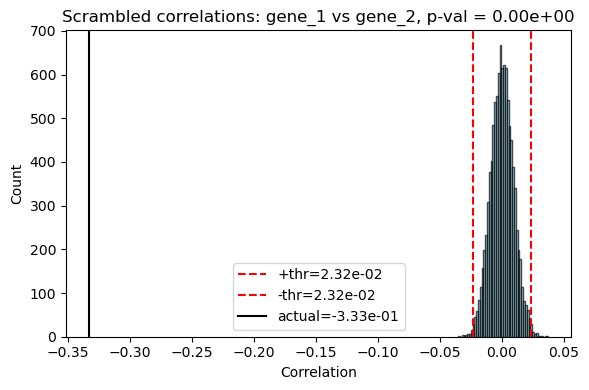

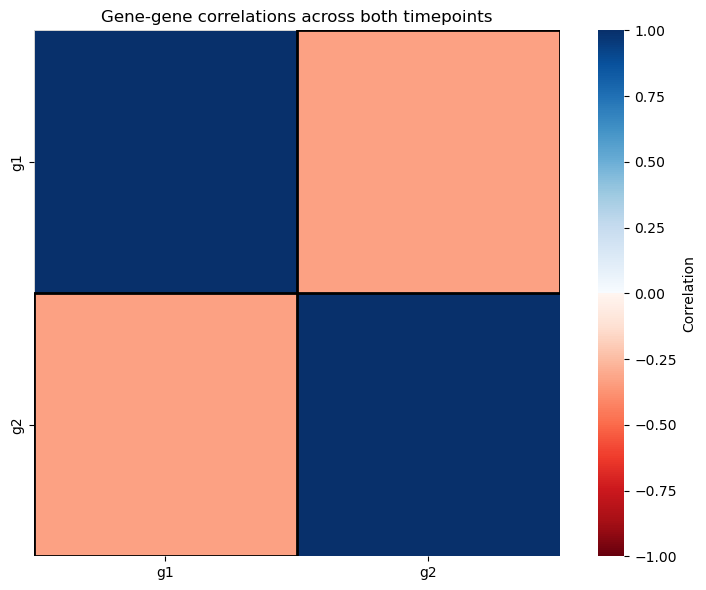

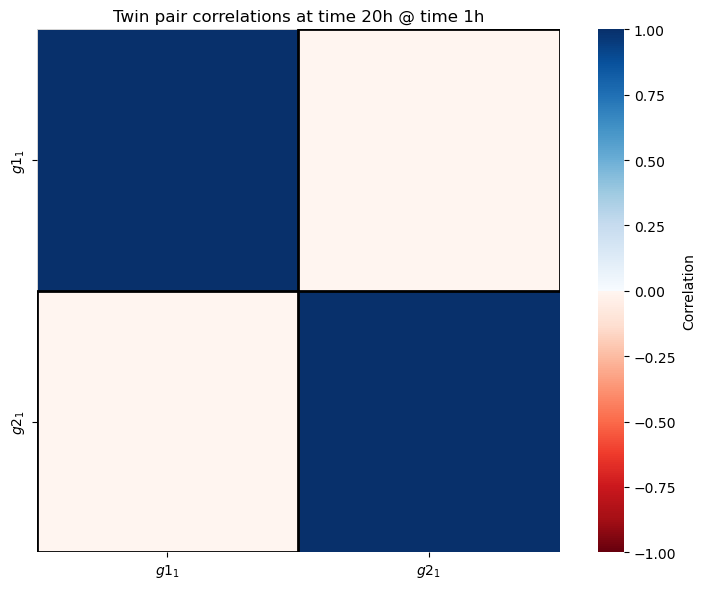

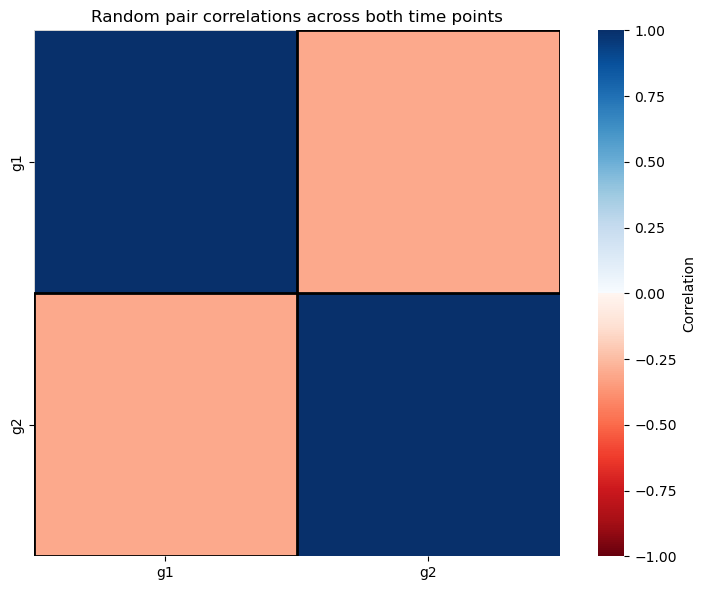

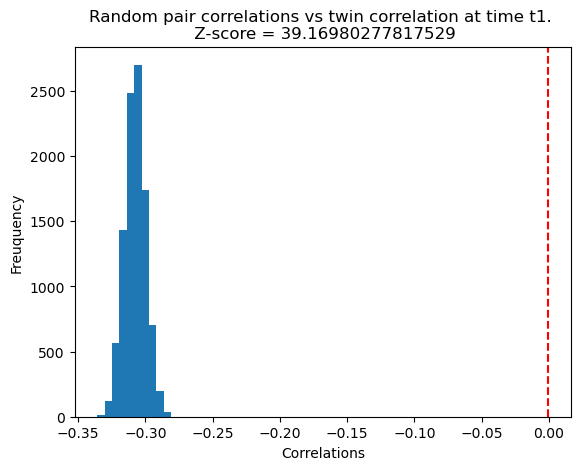

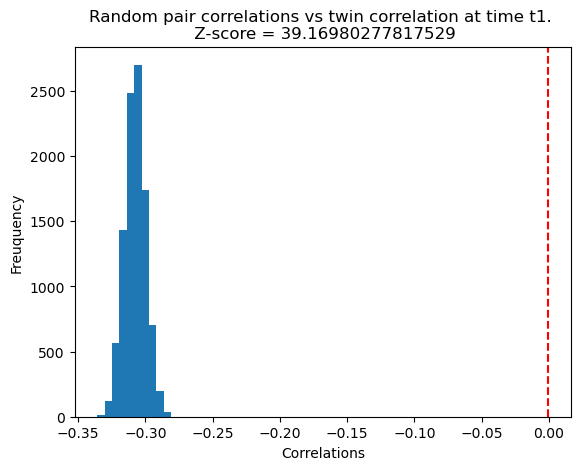

Testing for multiple states. Correlation at time t1 = -0.0005121758756174901 and at time t2 = 0.0002302261485933174
Testing for multiple states. Correlation at time t1 = -0.0005121758756174901 and at time t2 = 0.0002302261485933174

1. No Regulation
  (none)

2. Single-State Regulation
  (none)

3. Multiple States (No Regulation)
  (none)

4. Multiple States with Regulation
  gene_1 - gene_2
  gene_2 - gene_1


//home/gzu5140/Keerthana_b1042/grnInference/code/TwINFER/TwINFER_function_scripts/correlation_analysis_helpers.py:577: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min(y_vals) - 0.3 * y_range, max(y_vals) + 0.3 * y_range)


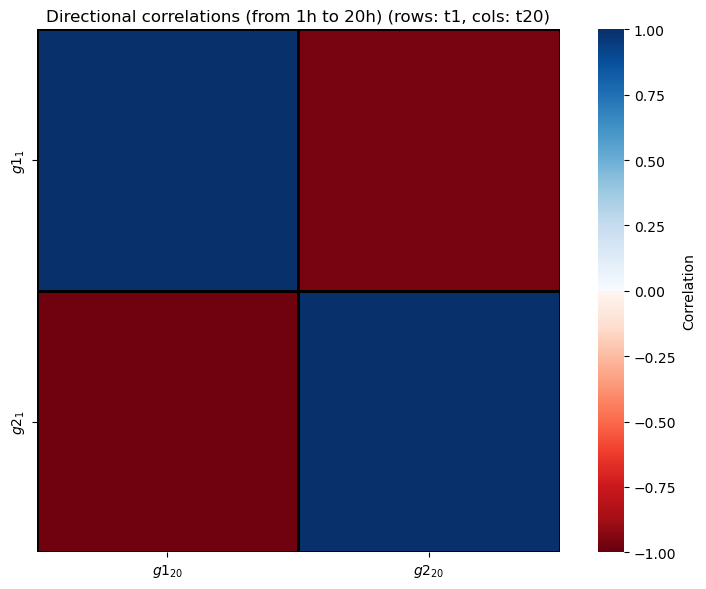

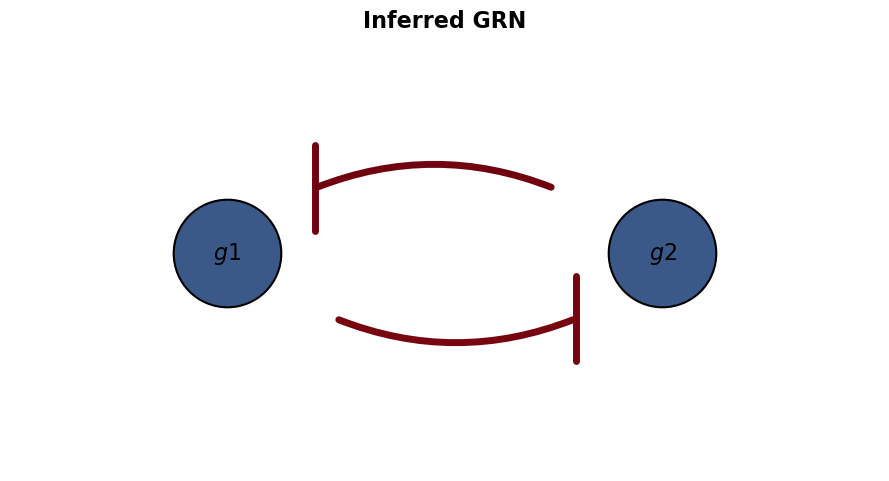

In [12]:
plot, correlation_matrices = infer_using_twinfer(path_to_simulation_file, base_config, t1, t2,
                            check_for_steady_state=False, plot_correlation_matrices_as_heatmap=True, have_any_output=True)

In [13]:
correlation_matrices.keys()

dict_keys(['direction_matrix', 'direction_raw_matrix', 'pairwise_gene_gene_correlation_matrix', 'twin_pair_correlation_matrix_t2', 'random_pair_correlation_matrix_t2', 'twin_pair_correlation_matrix_t1', 'random_pair_correlation_matrix_t1'])

## Plotting networks from matrices

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def find_global_correlation_range(data_folder):
    """
    Find the global min and max correlation values across all CSV files.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing correlation matrix CSV files
        
    Returns
    -------
    tuple : (global_min, global_max)
    """
    csv_files = glob.glob(str(Path(data_folder) / "*.csv"))
    
    all_values = []
    for file_path in csv_files:
        df = pd.read_csv(file_path, index_col=0)
        # Get off-diagonal values only (exclude self-correlations of 1.0)
        values = df.values[np.triu_indices_from(df.values, k=1)]
        values = np.concatenate([values, df.values[np.tril_indices_from(df.values, k=-1)]])
        all_values.extend(values)
    
    return np.min(all_values), np.max(all_values)

def plot_all_correlations_common_scale(data_folder, output_folder=None, 
                                     figsize_per_plot=(4, 3), 
                                     use_symmetric_scale=True):
    """
    Plot all correlation matrices with a common scale.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing correlation matrix CSV files
    output_folder : str, optional
        Path to save plots. If None, plots are displayed
    figsize_per_plot : tuple
        Size of each individual plot
    use_symmetric_scale : bool
        Whether to use symmetric scale around 0 (recommended for correlations)
    """
    
    # Find global range
    global_min, global_max = find_global_correlation_range(data_folder)
    print(f"Global correlation range: {global_min:.3f} to {global_max:.3f}")
    
    # Set scale
    if use_symmetric_scale:
        # Use symmetric scale centered at 0
        max_abs = max(abs(global_min), abs(global_max))
        vmin, vmax = -max_abs, max_abs
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
        cmap = 'RdBu_r'  # or use your custom colormap
    else:
        # Use actual min/max range
        vmin, vmax = global_min, global_max
        norm = None
        cmap = 'RdBu_r'
    
    # Get all CSV files
    csv_files = glob.glob(str(Path(data_folder) / "*.csv"))
    csv_files.sort()  # Sort for consistent ordering
    
    # Plot each matrix
    for file_path in csv_files:
        filename = Path(file_path).stem
        
        # Load correlation matrix
        corr_matrix = pd.read_csv(file_path, index_col=0)
        
        # Create plot
        fig, ax = plt.subplots(figsize=figsize_per_plot)
        
        # Create heatmap with fixed scale
        heatmap = sns.heatmap(
            corr_matrix,
            ax=ax,
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt='.3f',
            square=True,
            cbar_kws={'label': 'Correlation'},
            linewidths=0.5,
            linecolor='lightgray',
            center=0 if use_symmetric_scale else None
        )
        
        # Format labels
        gene_labels = [label.replace('gene_', 'g') for label in corr_matrix.index]
        ax.set_xticklabels(gene_labels)
        ax.set_yticklabels(gene_labels)
        
        # Set title
        ax.set_title(filename.replace('_', ' ').title(), fontsize=12, pad=10)
        
        plt.tight_layout()
        
        # Save or show
        import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def find_global_correlation_range(data_folder):
    """
    Find the global min and max correlation values across all CSV files.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing correlation matrix CSV files
        
    Returns
    -------
    tuple : (global_min, global_max)
    """
    csv_files = glob.glob(str(Path(data_folder) / "*.csv"))
    
    all_values = []
    for file_path in csv_files:
        df = pd.read_csv(file_path, index_col=0)
        # Get off-diagonal values only (exclude self-correlations of 1.0)
        values = df.values[np.triu_indices_from(df.values, k=1)]
        values = np.concatenate([values, df.values[np.tril_indices_from(df.values, k=-1)]])
        all_values.extend(values)
    
    return np.min(all_values), np.max(all_values)

def plot_all_correlations_common_scale(data_folder, output_folder=None, 
                                     figsize_per_plot=(4, 3), 
                                     use_symmetric_scale=True):
    """
    Plot all correlation matrices with a common scale.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing correlation matrix CSV files
    output_folder : str, optional
        Path to save plots. If None, plots are displayed
    figsize_per_plot : tuple
        Size of each individual plot
    use_symmetric_scale : bool
        Whether to use symmetric scale around 0 (recommended for correlations)
    """
    
    # Find global range
    global_min, global_max = find_global_correlation_range(data_folder)
    print(f"Global correlation range: {global_min:.3f} to {global_max:.3f}")
    
    # Set scale
    if use_symmetric_scale:
        # Use symmetric scale centered at 0
        max_abs = max(abs(global_min), abs(global_max))
        vmin, vmax = -max_abs, max_abs
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
        cmap = 'RdBu_r'  # or use your custom colormap
    else:
        # Use actual min/max range
        vmin, vmax = global_min, global_max
        norm = None
        cmap = 'RdBu_r'
    
    # Get all CSV files
    csv_files = glob.glob(str(Path(data_folder) / "*.csv"))
    csv_files.sort()  # Sort for consistent ordering
    
    # Plot each matrix
    for file_path in csv_files:
        filename = Path(file_path).stem
        
        # Load correlation matrix
        corr_matrix = pd.read_csv(file_path, index_col=0)
        
        # Create plot
        fig, ax = plt.subplots(figsize=figsize_per_plot)
        
        # Create heatmap with fixed scale
        heatmap = sns.heatmap(
            corr_matrix,
            ax=ax,
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt='.3f',
            square=True,
            cbar_kws={'label': 'Correlation'},
            linewidths=0.5,
            linecolor='lightgray',
            center=0 if use_symmetric_scale else None
        )
        
        # Format labels
        gene_labels = [label.replace('gene_', 'g') for label in corr_matrix.index]
        ax.set_xticklabels(gene_labels)
        ax.set_yticklabels(gene_labels)
        
        # Set title
        ax.set_title(filename.replace('_', ' ').title(), fontsize=12, pad=10)
        
        plt.tight_layout()
        
        # Save or show
        if output_folder:
            # Save as PNG
            png_path = Path(output_folder) / f"{filename}_correlation.png"
            png_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(png_path, dpi=300, bbox_inches='tight')
            
            # Save as PDF with your specifications
            pdf_path = Path(output_folder) / f"{filename}.pdf"
            fig.savefig(
                pdf_path,
                bbox_inches='tight',     # Remove extra whitespace
                facecolor='white',       # White background
                edgecolor='none',        # No border
                transparent=False,       # Not transparent
                format='pdf'             # Explicitly specify PDF format
            )
            print(f"Saved PNG: {png_path}")
            print(f"Saved PDF: {pdf_path}")
            plt.close()
        else:
            plt.show()
def create_comparison_grid(data_folder, output_path=None, ncols=3, 
                         figsize=(12, 8), use_symmetric_scale=True):
    """
    Create a grid of all correlation matrices for easy comparison.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing correlation matrix CSV files
    output_path : str, optional
        Path to save the combined plot
    ncols : int
        Number of columns in the grid
    figsize : tuple
        Size of the entire figure
    use_symmetric_scale : bool
        Whether to use symmetric scale around 0
    """
    
    # Find global range
    global_min, global_max = find_global_correlation_range(data_folder)
    
    # Set scale
    if use_symmetric_scale:
        max_abs = max(abs(global_min), abs(global_max))
        vmin, vmax = -max_abs, max_abs
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
        cmap = 'RdBu_r'
    else:
        vmin, vmax = global_min, global_max
        norm = None
        cmap = 'RdBu_r'
    
    # Get all CSV files
    csv_files = glob.glob(str(Path(data_folder) / "*.csv"))
    csv_files.sort()
    
    # Calculate grid dimensions
    nfiles = len(csv_files)
    nrows = int(np.ceil(nfiles / ncols))
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = [axes]
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Plot each matrix
    for i, file_path in enumerate(csv_files):
        filename = Path(file_path).stem
        corr_matrix = pd.read_csv(file_path, index_col=0)
        
        ax = axes[i]
        
        # Create heatmap
        sns.heatmap(
            corr_matrix,
            ax=ax,
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt='.2f',  # Shorter format for grid view
            square=True,
            cbar=False,  # We'll add a single colorbar later
            linewidths=0.5,
            linecolor='lightgray'
        )
        
        # Format labels
        gene_labels = [label.replace('gene_', 'g') for label in corr_matrix.index]
        ax.set_xticklabels(gene_labels, fontsize=8)
        ax.set_yticklabels(gene_labels, fontsize=8)
        ax.set_title(filename.replace('_', ' ').title(), fontsize=10)
    
    # Hide unused subplots
    for i in range(nfiles, len(axes)):
        axes[i].set_visible(False)
    
    # Add single colorbar
    # Create a dummy mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[:nfiles], shrink=0.6, aspect=20)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Grid plot saved: {output_path}")
    else:
        plt.show()

In [ ]:
# Example usage:
if __name__ == "__main__":
    data_folder = "/home/gzu5140/Keerthana_b1042/grnInference/plot_data/figure_3_v3/"
    
    # Option 1: Plot individual matrices with common scale
    plot_all_correlations_common_scale(
        data_folder, 
        output_folder="/home/gzu5140/Keerthana_b1042/grnInference/plots/figure_3_v3/",
        use_symmetric_scale=True
    )
    

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import spearmanr

# ==========================================
# CORRELATION FUNCTIONS
# ==========================================

def compute_correlation_matrix_fast(gene_matrix_t1, gene_matrix_t2, gene_list, 
                                   gene_pairs=None, threshold=None):
    """Fast correlation computation using pure NumPy operations."""
    n_genes = len(gene_list)
    gene_to_idx = {gene: i for i, gene in enumerate(gene_list)}
    
    # Initialize matrices
    raw_matrix = np.zeros((n_genes, n_genes))
    
    # Determine which pairs to compute
    if gene_pairs is None:
        pairs_to_compute = [(i, j) for i in range(n_genes) for j in range(n_genes)]
    else:
        pairs_to_compute = []
        for gene_1, gene_2 in gene_pairs:
            if gene_1 in gene_to_idx and gene_2 in gene_to_idx:
                i, j = gene_to_idx[gene_1], gene_to_idx[gene_2]
                pairs_to_compute.append((i, j))
    
    # Compute correlations for specified pairs
    for i, j in pairs_to_compute:
        corr = spearmanr(gene_matrix_t1[i, :], gene_matrix_t2[j, :]).correlation
        if np.isnan(corr):
            corr = 0.0
        raw_matrix[i, j] = corr
    
    # Convert to DataFrames
    raw_df = pd.DataFrame(raw_matrix, index=gene_list, columns=gene_list)
    
    return {"raw_matrix": raw_df}

def single_cell_shuffle(gene_matrix_t1, gene_matrix_t2, gene_list, gene_pairs, threshold):
    """Perform a single cell shuffling iteration."""
    n_cells = gene_matrix_t1.shape[1]
    shuffled_indices = np.random.permutation(n_cells)
    shuffled_matrix_t2 = gene_matrix_t2[:, shuffled_indices]
    return compute_correlation_matrix_fast(gene_matrix_t1, shuffled_matrix_t2, gene_list, gene_pairs, threshold)

def prepare_twin_data(df, gene_list, t1=10, t2=20):
    """
    Prepare twin data from simulation CSV file.
    Based on your data loading process.
    """
    
    # Basic checks
    if 'clone_id' not in df.columns:
        raise ValueError("CSV must contain 'clone_id' column")
    if 'time_step' not in df.columns:
        raise ValueError("CSV must contain 'time_step' column")
    
    n_clones_simulation = df['clone_id'].nunique()
    
    # Shuffle all clone IDs (like in your code)
    np.random.seed(101010)
    clone_ids_shuffled = np.random.permutation(n_clones_simulation)
    
    # Split into ratios (like in your code)
    n1 = n2 = n_clones_simulation // 4
    across_t_clones = clone_ids_shuffled[n1 + n2:]
    
    # Get across-time twins (like in your code)
    across_t_twin1 = df[
        (df['clone_id'].isin(across_t_clones)) & 
        (df['time_step'] == t1) & 
        (df['replicate'] == 1)
    ].reset_index(drop=True)
    
    across_t_twin2 = df[
        (df['clone_id'].isin(across_t_clones)) & 
        (df['time_step'] == t2) & 
        (df['replicate'] == 2)
    ].reset_index(drop=True)
    
    return across_t_twin1, across_t_twin2

def analyze_single_file(file_path, gene_list, t1=10, t2=20, n_shuffles=1000):
    """
    Analyze a single CSV file to get correlations and thresholds.
    """
    
    print(f"  Analyzing {os.path.basename(file_path)}")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Prepare twin data
    rep_0_t1, rep_1_t2 = prepare_twin_data(df, gene_list, t1, t2)
    
    if len(rep_0_t1) == 0 or len(rep_1_t2) == 0:
        print(f"    Warning: No twin data found")
        return None
    
    # Extract gene matrices
    gene_matrix_t1 = []
    gene_matrix_t2 = []
    
    for gene in gene_list:
        # Look for gene columns
        gene_col_t1 = f"{gene}_mRNA" if f"{gene}_mRNA" in rep_0_t1.columns else None
        gene_col_t2 = f"{gene}_mRNA" if f"{gene}_mRNA" in rep_1_t2.columns else None
        
        if not gene_col_t1:
            matching_cols = [col for col in rep_0_t1.columns if gene in col and 'mRNA' in col]
            gene_col_t1 = matching_cols[0] if matching_cols else None
            
        if not gene_col_t2:
            matching_cols = [col for col in rep_1_t2.columns if gene in col and 'mRNA' in col]
            gene_col_t2 = matching_cols[0] if matching_cols else None
        
        if gene_col_t1 and gene_col_t2:
            gene_matrix_t1.append(rep_0_t1[gene_col_t1].values)
            gene_matrix_t2.append(rep_1_t2[gene_col_t2].values)
        else:
            print(f"    Warning: Could not find {gene} data")
            return None
    
    gene_matrix_t1 = np.array(gene_matrix_t1)
    gene_matrix_t2 = np.array(gene_matrix_t2)
    
    gene_pairs = [('gene_1', 'gene_2'), ('gene_2', 'gene_1'), ('gene_1', 'gene_1'), ('gene_2', 'gene_2')]
    
    # Get actual correlations
    actual_results = compute_correlation_matrix_fast(gene_matrix_t1, gene_matrix_t2, gene_list, gene_pairs, None)
    actual_matrix = actual_results['raw_matrix']
    
    gene_1_to_2 = actual_matrix.loc['gene_1', 'gene_2']
    gene_2_to_1 = actual_matrix.loc['gene_2', 'gene_1']
    
    # Get shuffled correlations for thresholds
    shuffled_results = Parallel(n_jobs=-1, verbose=0)(
        delayed(single_cell_shuffle)(gene_matrix_t1, gene_matrix_t2, gene_list, gene_pairs)
        for _ in range(n_shuffles)
    )
    
    # Calculate thresholds
    shuffled_12 = []
    shuffled_21 = []
    
    for result in shuffled_results:
        shuffled_matrix = result['raw_matrix']
        shuffled_12.append(abs(shuffled_matrix.loc['gene_1', 'gene_2']))
        shuffled_21.append(abs(shuffled_matrix.loc['gene_2', 'gene_1']))
    
    threshold_12 = np.percentile(shuffled_12, 99) if shuffled_12 else 0.05
    threshold_21 = np.percentile(shuffled_21, 99) if shuffled_21 else 0.05
    threshold_combined = np.percentile(shuffled_12 + shuffled_21, 99)
    
    print(f"    Correlations: gene_1→gene_2={gene_1_to_2:.3f}, gene_2→gene_1={gene_2_to_1:.3f}")
    print(f"    Thresholds: gene_1→gene_2={threshold_12:.3f}, gene_2→gene_1={threshold_21:.3f}")
    
    return {
        'gene_1_to_gene_2': gene_1_to_2,
        'gene_2_to_gene_1': gene_2_to_1,
        'threshold_12': threshold_12,
        'threshold_21': threshold_21,
        'threshold_combined': threshold_combined
    }

# ==========================================
# MAIN ANALYSIS FUNCTIONS
# ==========================================

def collect_all_data(base_path, folder_names, gene_list, t1=10, t2=20, n_shuffles=1000):
    """
    Collect correlations and thresholds from all files.
    """
    
    all_results = []
    
    for folder in folder_names:
        folder_path = os.path.join(base_path, folder)
        print(f"Processing {folder}...")
        
        if not os.path.exists(folder_path):
            print(f"  Folder not found: {folder_path}")
            continue
            
        # Find CSV files
        csv_files = [f for f in os.listdir(folder_path) if f.startswith('df_') and f.endswith('.csv')]
        print(f"  Found {len(csv_files)} files")
        
        for csv_file in csv_files:
            file_path = os.path.join(folder_path, csv_file)
            
            try:
                result = analyze_single_file(file_path, gene_list, t1, t2, n_shuffles)
                
                if result:
                    result['Condition'] = folder
                    result['File'] = csv_file
                    all_results.append(result)
                    
            except Exception as e:
                print(f"    Error with {csv_file}: {e}")
                continue
    
    return pd.DataFrame(all_results)

def create_illustrator_plots(df_results, save_dir):
    """
    Create two publication-ready PDF plots suitable for Illustrator.
    """
    
    # Set publication style based on your reference
    plt.rcParams.update({
        'svg.fonttype': 'none',  # Keep text as text, not paths
        'font.family': 'sans-serif',  # Use system fonts
        'figure.dpi': 300
    })
    
    # Define colors for the 6 conditions
    colors = ['#bc0f58', '#194a9e', '#006937', '#ee9127', '#8a2be2', '#ff4500']
    
    # ==========================================
    # PLOT 1: CORRELATIONS WITH THRESHOLD LINES
    # ==========================================
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # REMOVE ALL BACKGROUNDS
    fig.patch.set_facecolor('none')  # Figure background transparent
    ax.set_facecolor('none')         # Axes background transparent
    
    conditions = df_results['Condition'].unique()
    
    # Prepare data for each condition
    all_values_12 = []  # gene_1 -> gene_2
    all_values_21 = []  # gene_2 -> gene_1
    all_thresholds_12 = []
    all_thresholds_21 = []
    
    for condition in conditions:
        condition_data = df_results[df_results['Condition'] == condition]
        vals_12 = condition_data['gene_1_to_gene_2'].values.tolist()
        vals_21 = condition_data['gene_2_to_gene_1'].values.tolist()
        thresh_12 = condition_data['threshold_12'].values.tolist()
        thresh_21 = condition_data['threshold_21'].values.tolist()
        
        all_values_12.append(vals_12)
        all_values_21.append(vals_21)
        all_thresholds_12.append(thresh_12)
        all_thresholds_21.append(thresh_21)
    
    # Flatten thresholds for range calculation
    flat_thresholds = [item for sublist in all_thresholds_12 + all_thresholds_21 for item in sublist]
    
    # Add threshold range background
    x_range = np.arange(0.5, len(conditions) + 0.5, 0.01)
    ax.fill_between(x_range, 
                    np.min(flat_thresholds), 
                    np.max(flat_thresholds), 
                    alpha=0.2, 
                    color="lightgray", 
                    edgecolor="black", 
                    linestyle="--", 
                    linewidth=1)
    
    # Add threshold lines
    ax.axhline(np.mean(flat_thresholds), linestyle="--", color="black", linewidth=1, alpha=0.7)
    ax.axhline(-np.mean(flat_thresholds), linestyle="--", color="black", linewidth=1, alpha=0.7)
    
    # Create boxplots for gene_1 -> gene_2
    positions_12 = [i - 0.2 for i in range(1, len(conditions) + 1)]
    box_12 = ax.boxplot(all_values_12, positions=positions_12, patch_artist=True, 
                        showfliers=False, widths=0.3)
    
    # Create boxplots for gene_2 -> gene_1  
    positions_21 = [i + 0.2 for i in range(1, len(conditions) + 1)]
    box_21 = ax.boxplot(all_values_21, positions=positions_21, patch_artist=True, 
                        showfliers=False, widths=0.3)
    
    # Style gene_1 -> gene_2 boxplots (red tones)
    for i, (patch, color) in enumerate(zip(box_12['boxes'], colors)):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.7)
        patch.set_clip_on(False)
    
    for whisker in box_12['whiskers'] + box_12['caps'] + box_12['medians']:
        whisker.set_color('red')
        whisker.set_clip_on(False)
    
    # Style gene_2 -> gene_1 boxplots (blue tones)  
    for i, (patch, color) in enumerate(zip(box_21['boxes'], colors)):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.4)
        patch.set_clip_on(False)
    
    for whisker in box_21['whiskers'] + box_21['caps'] + box_21['medians']:
        whisker.set_color('blue')
        whisker.set_clip_on(False)
    
    # Remove all text and labels
    ax.set_xticks(range(1, len(conditions) + 1))
    ax.tick_params(axis='both', which='both', 
                bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True,
                length=4, width=1)
    
    
    plt.savefig(os.path.join(save_dir, 'correlations_with_thresholds_with_label.png'), 
                format='png', bbox_inches='tight', 
                facecolor='none', edgecolor='none', transparent=True)
    plt.show()
    
    # ==========================================
    # PLOT 2: THRESHOLD BOX PLOTS (6x2 columns)
    # ==========================================
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # REMOVE ALL BACKGROUNDS
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    
    # Create side-by-side boxplots for thresholds
    positions_12 = [i - 0.2 for i in range(1, len(conditions) + 1)]
    box_thresh_12 = ax.boxplot(all_thresholds_12, positions=positions_12, 
                               patch_artist=True, showfliers=False, widths=0.3)
    
    positions_21 = [i + 0.2 for i in range(1, len(conditions) + 1)]
    box_thresh_21 = ax.boxplot(all_thresholds_21, positions=positions_21, 
                               patch_artist=True, showfliers=False, widths=0.3)
    
    # Style threshold boxplots
    for i, (patch, color) in enumerate(zip(box_thresh_12['boxes'], colors)):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.7)
        patch.set_clip_on(False)
    
    for whisker in box_thresh_12['whiskers'] + box_thresh_12['caps'] + box_thresh_12['medians']:
        whisker.set_color('red')
        whisker.set_clip_on(False)
    
    for i, (patch, color) in enumerate(zip(box_thresh_21['boxes'], colors)):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.4)
        patch.set_clip_on(False)
    
    for whisker in box_thresh_21['whiskers'] + box_thresh_21['caps'] + box_thresh_21['medians']:
        whisker.set_color('blue')
        whisker.set_clip_on(False)
    
    # Add mean threshold line
    ax.axhline(np.mean(flat_thresholds), linestyle="--", color="black", linewidth=1, alpha=0.7)
    
    # Remove all text and labels
    ax.set_xticks(range(1, len(conditions) + 1))
    ax.tick_params(axis='both', which='both', 
                bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True,
                length=4, width=1)

    

    
    # plt.savefig(os.path.join(save_dir, 'threshold_boxplots_with_label.png'), 
    #             format='png', bbox_inches='tight',
    #             facecolor='none', edgecolor='none', transparent=True)
    plt.show()
    
    print(f"Saved clean PDFs to {save_dir}:")
    print("1. correlations_with_thresholds.pdf")
    print("2. threshold_boxplots.pdf")
    
    return None

def find_significant(df_results):
    """
    Find correlations above their thresholds.
    """
    
    significant = []
    
    for _, row in df_results.iterrows():
        if abs(row['gene_1_to_gene_2']) > row['threshold_12']:
            significant.append({
                'Condition': row['Condition'], 'File': row['File'],
                'Direction': 'gene_1→gene_2', 'Correlation': row['gene_1_to_gene_2'],
                'Threshold': row['threshold_12']
            })
            
        if abs(row['gene_2_to_gene_1']) > row['threshold_21']:
            significant.append({
                'Condition': row['Condition'], 'File': row['File'],
                'Direction': 'gene_2→gene_1', 'Correlation': row['gene_2_to_gene_1'],
                'Threshold': row['threshold_21']
            })
    
    return pd.DataFrame(significant)

def main():
    """
    Main analysis function - no external dependencies needed!
    """
    
    # Parameters
    base_path = "/home/gzu5140/Keerthana_b1042/grnInference/simulation_data/median_parameter_simulations/figure_3_simulations/"
    folder_names = ["A_B", "A_rep_B", "A_rep_B_B_rep_A", "A_rep_B_B_to_A", "A_to_B", "A_to_B_B_to_A"]
    gene_list = ['gene_1', 'gene_2']
    t1, t2 = 1, 20  # Adjust these to your time points
    n_shuffles = 1000  # Number of shuffles for threshold calculation
    
    print("=== Pure Shuffling Correlation Analysis ===")
    print("(No TwINFER function needed!)")
    
    # Collect all data
    print("\n1. Collecting data from all files...")
    df_results = collect_all_data(base_path, folder_names, gene_list, t1, t2, n_shuffles)
    
    if df_results.empty:
        print("No data collected!")
        return
    
    print(f"Collected {len(df_results)} files from {df_results['Condition'].nunique()} conditions")
    
    # Create Illustrator-ready plots
    print("\n2. Creating publication plots...")
    save_dir = "/home/gzu5140/Keerthana_b1042/grnInference/plots/figure_3_v3/"
    os.makedirs(save_dir, exist_ok=True)
    
    thresh_df = create_illustrator_plots(df_results, save_dir)
    
    # Find significant correlations
    print("\n3. Finding significant correlations...")
    df_significant = find_significant(df_results)
    
    if not df_significant.empty:
        print(f"Found {len(df_significant)} significant correlations:")
        print(df_significant)
    else:
        print("No significant correlations found.")
    
    # Summary stats
    print("\n4. Summary statistics:")
    summary = df_results.groupby('Condition')[['gene_1_to_gene_2', 'gene_2_to_gene_1']].describe()
    print(summary)
    
    return df_results, thresh_df, df_significant

if __name__ == "__main__":
    df_results, thresh_df, df_significant = main()

=== Pure Shuffling Correlation Analysis ===
(No TwINFER function needed!)

1. Collecting data from all files...
Processing A_B...
  Found 1 files
  Analyzing df_rows_0_1_08082025_093223_ncells_6000_A_B_rep_0.csv


KeyboardInterrupt: 

In [42]:
df_results.to_csv("/home/gzu5140/Keerthana_b1042/grnInference/plot_data/figure_3/box_plot_data.csv")